# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

В процессе  анализа нужно:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
    * Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.


На каждый вопрос необходимо ответить с уровнем значимости $\alpha=0.05$.    

Данные содержат следующие столбцы:
*   work_year - Год, в котором была выплачена зарплата.
*   experience_level - 	Опыт работы на этой должности в течение года со следующими возможными значениями:
    *   EN — Entry-level/Junior;
    *   MI — Mid-level/Intermediate;
    *   SE — Senior-level/Expert;
    *   EX — Executive-level/Director.
*   employment_type - Тип трудоустройства для этой роли:
    *   PT — неполный рабочий день;
    *   FT — полный рабочий день;
    *   CT — контракт;
    *   FL — фриланс.
*   job_title - Роль, в которой соискатель работал в течение года.
*   salary - Общая выплаченная валовая сумма заработной платы.
*   salary_currency - Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
*   salary_in_usd - Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
*   employee_residence - Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
*   remote_ratio - Общий объём работы, выполняемой удалённо. Возможные значения:
    *   0 — удалённой работы нет (менее 20 %);
    *   50 — частично удалённая работа;
    *   100 — полностью удалённая работа (более 80 %).
*   company_location - Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
*   company_size - Среднее количество людей, работавших в компании в течение года:
    *   S — менее 50 сотрудников (небольшая компания);
    *   M — от 50 до 250 сотрудников (средняя компания);
    *   L — более 250 сотрудников (крупная компания).      


Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

In [112]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.descriptivestats import sign_test
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# загружаем датасет
data = pd.read_csv('C:\VS Code/asset/ds_salaries.csv', index_col='Unnamed: 0')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [60]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений).

Проверим на наличие полных дубликатов

In [62]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

# Удаляем дубликаты:
data = data.drop_duplicates()
print('Размер таблицы после удаления дубликатов: {}'.format(data.shape))

Количество дубликатов: 42
Размер таблицы после удаления дубликатов: (565, 11)


Удалим столбцы:

* "salary" и "salary_currency" - в столбце " salary_in_usd " приведена зарплата к единой валюте

In [63]:
data.drop(['salary', 'salary_currency'], axis=1, inplace=True)

# итоговая таблица после удаления столбцов
data.head()

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L


1. К числовым признакам  относятся следующие столбцы:
 * work_year
 * salary_in_usd
2. К категориальным :
 * experience_level
 * employment_type
 * job_title
 * employee_residence
 * remote_ratio (хоть и представлено в цифровом выражении считаю, что это  категориальный признак т.к. можно было эти  данные представить с помощью букв)
 * company_location
 * company_size  

In [64]:
'''data_category = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
for col in data_category:
    data[col] = data[col].astype('category')
    
data.info()   '''

"data_category = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']\nfor col in data_category:\n    data[col] = data[col].astype('category')\n    \ndata.info()   "

Расмотрим количество уникальных значений для Датасета

In [65]:
data.nunique()



work_year               3
experience_level        4
employment_type         4
job_title              50
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

По техническому заданию нужно рассмотреть влияния факторов на заработную плату специалистов Data Scientist(Именно с такой формулировкой), поэтому преобразования в столбце job_title не допустимы в данном случае.
Рассмотрим столбцы  employee_residence и company_location, покажем долю каждого уникального значения:  

In [66]:
res = data['employee_residence'].value_counts(normalize=True) * 100
res


employee_residence
US    52.212389
GB     7.610619
IN     5.309735
CA     4.778761
DE     4.247788
FR     3.185841
ES     2.654867
GR     2.123894
JP     1.238938
PT     1.061947
BR     1.061947
PK     1.061947
NL     0.884956
PL     0.707965
IT     0.707965
RU     0.707965
AE     0.530973
AT     0.530973
VN     0.530973
TR     0.530973
AU     0.530973
RO     0.353982
BE     0.353982
SG     0.353982
SI     0.353982
DK     0.353982
HU     0.353982
NG     0.353982
MX     0.353982
BO     0.176991
MY     0.176991
TN     0.176991
IE     0.176991
DZ     0.176991
AR     0.176991
CZ     0.176991
JE     0.176991
LU     0.176991
PR     0.176991
RS     0.176991
EE     0.176991
CL     0.176991
HK     0.176991
KE     0.176991
MD     0.176991
CO     0.176991
IR     0.176991
CN     0.176991
MT     0.176991
UA     0.176991
IQ     0.176991
HN     0.176991
BG     0.176991
HR     0.176991
PH     0.176991
NZ     0.176991
CH     0.176991
Name: proportion, dtype: float64

In [67]:
sum_five_el = 0
for i in range(5):
    sum_five_el += res[i]

print(f'Доля пяти популярных Employee_residence: {round(sum_five_el, 2)}  %')    

Доля пяти популярных Employee_residence: 74.16  %


74,16 %  наименований стран проживания сотрудника приходится на 5 наименваний, для сокращения уникальных значений остальные  переименуем в 'other'

In [68]:
popular_employee_residence = data['employee_residence'].value_counts().nlargest(5).index
data['employee_residence'] = data['employee_residence'].apply(lambda x: x if x in popular_employee_residence else 'other')
data['employee_residence'].value_counts(normalize=True) * 100


employee_residence
US       52.212389
other    25.840708
GB        7.610619
IN        5.309735
CA        4.778761
DE        4.247788
Name: proportion, dtype: float64

In [69]:
location = data['company_location'].value_counts(normalize=True) * 100
location

company_location
US    56.283186
GB     8.141593
CA     4.955752
DE     4.778761
IN     4.247788
FR     2.654867
ES     2.477876
GR     1.769912
JP     1.061947
NL     0.707965
AT     0.707965
PT     0.707965
PL     0.707965
LU     0.530973
PK     0.530973
BR     0.530973
AE     0.530973
MX     0.530973
AU     0.530973
TR     0.530973
DK     0.530973
IT     0.353982
CZ     0.353982
SI     0.353982
RU     0.353982
CH     0.353982
NG     0.353982
CN     0.353982
BE     0.353982
VN     0.176991
EE     0.176991
AS     0.176991
DZ     0.176991
MY     0.176991
MD     0.176991
KE     0.176991
SG     0.176991
CO     0.176991
IR     0.176991
CL     0.176991
MT     0.176991
IL     0.176991
UA     0.176991
IQ     0.176991
RO     0.176991
HR     0.176991
NZ     0.176991
HU     0.176991
HN     0.176991
IE     0.176991
Name: proportion, dtype: float64

In [70]:
sum_five_el = 0
for i in range(5):
    sum_five_el += location[i]

print(f'Доля пяти популярных company_location: {round(sum_five_el, 2)}  %')   

Доля пяти популярных company_location: 78.41  %


78,41 %  наименований стран главного офиса приходится на 5 наименваний, для сокращения уникальных значений остальные  переименуем в 'other'

In [71]:
popular_company_location = data['company_location'].value_counts().nlargest(5).index
data['company_location'] = data['company_location'].apply(lambda x: x if x in popular_employee_residence else 'other')
data['company_location'].value_counts(normalize=True) * 100

company_location
US       56.283186
other    21.592920
GB        8.141593
CA        4.955752
DE        4.778761
IN        4.247788
Name: proportion, dtype: float64

### Распределение размера зарплаты для всех соискателей

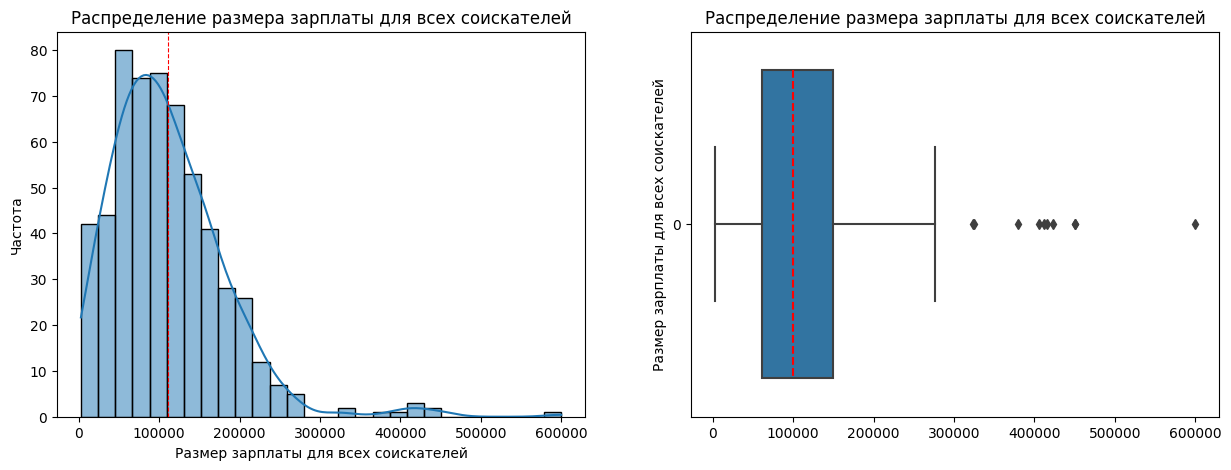

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data['salary_in_usd'],  kde=True, ax=axes[0])
axes[0].set(xlabel='Размер зарплаты для всех соискателей', ylabel='Частота')
axes[0].set_title('Распределение размера зарплаты для всех соискателей')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Размер зарплаты для всех соискателей')
axes[1].set_title('Распределение размера зарплаты для всех соискателей')

plt.show()

In [73]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Размер зарплаты']
data_agg

,Размер зарплаты
count,565.00
mean,110610.34
std,72280.70
min,2859.00
25%,60757.00
50%,100000.00
75%,150000.00
max,600000.00


Распределение страховых выплат отлично от нормального, имеются выбросы.

 ### Распределение размера зарплаты взависимости от года, когда она была выплачена

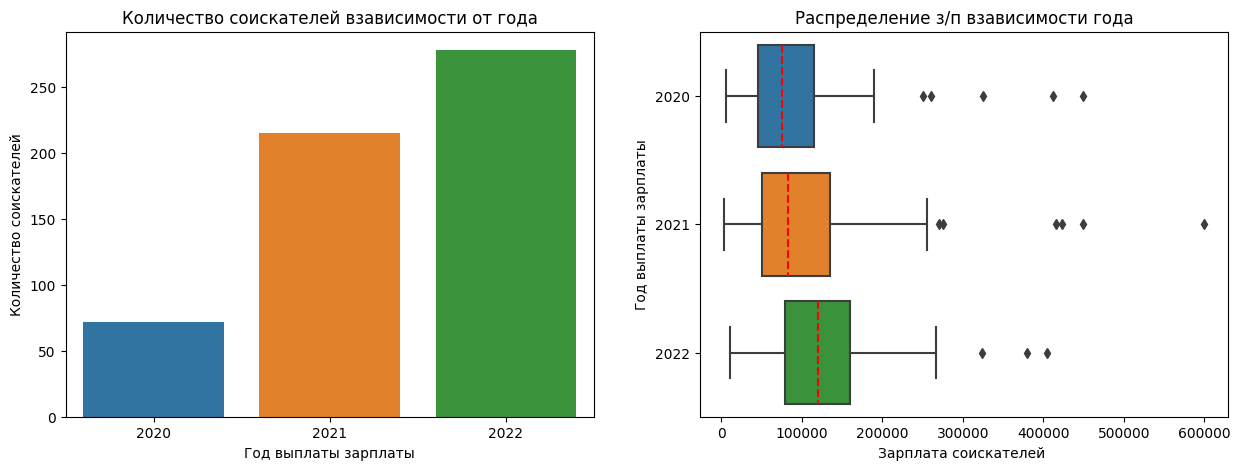

In [74]:
cnt_work_year = data['work_year'].value_counts().to_frame()
cnt_work_year.columns = ['count']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=cnt_work_year.index, y = cnt_work_year['count'], ax=axes[0])
axes[0].set(xlabel='Год выплаты зарплаты', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от года')

sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Год выплаты зарплаты')
axes[1].set_title('Распределение з/п взависимости года')
plt.show()


In [75]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от года, когда она была выплачена')
data_agg

Размера зарплаты взависимости от года, когда она была выплачена


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.00,82831.80,5707.0,45724.5,75544.0,115526.0,450000.0
2021,215.0,99430.41,80304.32,2859.0,50000.0,82528.0,135000.0,600000.0
2022,278.0,123089.10,59888.93,10000.0,78791.0,120000.0,160000.0,405000.0


Распределение зарплаты взависимости от года, когда она была выплачена отлично от нормального, имееются выбросы

### Распределение заработной платы взависимости от опыта работы на этой должности в течение года

In [76]:
cnt_experience_level = data['experience_level'].value_counts().to_frame()
cnt_experience_level.columns = ['count']

Text(0.5, 1.0, 'Распределение з/п взависимости от опыта работы')

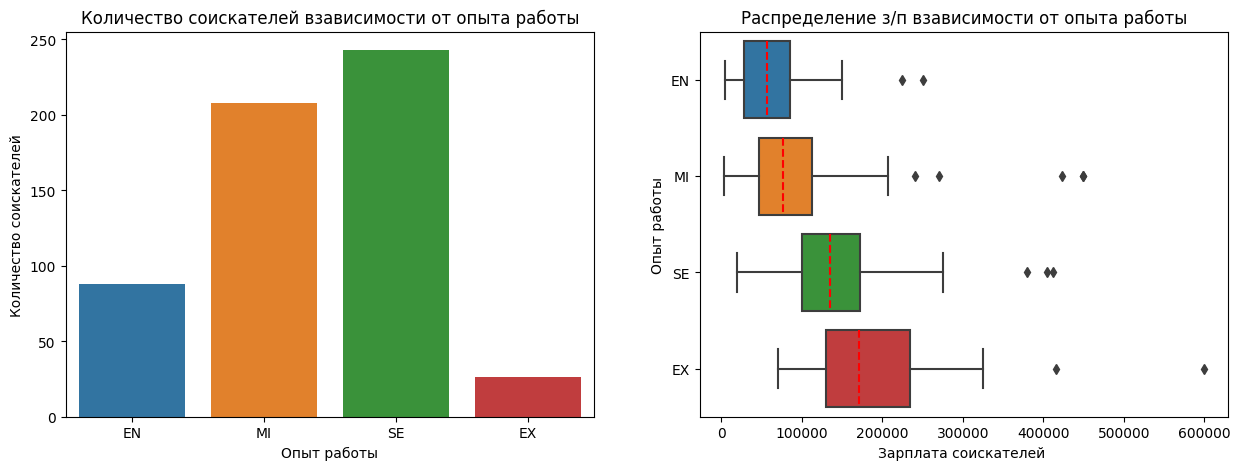

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_experience_level.index, y = cnt_experience_level['count'], ax=axes[0], order=['EN', 'MI', 'SE', 'EX'])
axes[0].set(xlabel='Опыт работы', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от опыта работы')


sns.boxplot(data, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, order=['EN', 'MI', 'SE', 'EX'])
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Опыт работы')
axes[1].set_title('Распределение з/п взависимости от опыта работы')

In [78]:
data_agg = data.groupby('experience_level')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от опыта работы')
data_agg

Размера зарплаты взависимости от опыта работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.32,44395.54,4000.0,27505.00,56500.0,85425.75,250000.0
EX,26.0,199392.04,117071.26,69741.0,130006.50,171437.5,233750.00,600000.0
MI,208.0,87793.00,64118.97,2859.0,47163.75,76940.0,112075.00,450000.0
SE,243.0,138374.88,59955.97,18907.0,99531.50,135000.0,171881.00,412000.0


Распределение зарплаты взависимости от опыта работы на  этой должности в течении года отлично от нормального, имееются выбросы

### Распределение заработной платы взависимости от типа трудоустройства

In [79]:
cnt_employment_type = data['employment_type'].value_counts().to_frame()
cnt_employment_type.columns = ['count']

Text(0.5, 1.0, 'Распределение з/п взависимости от типа трудоустройства')

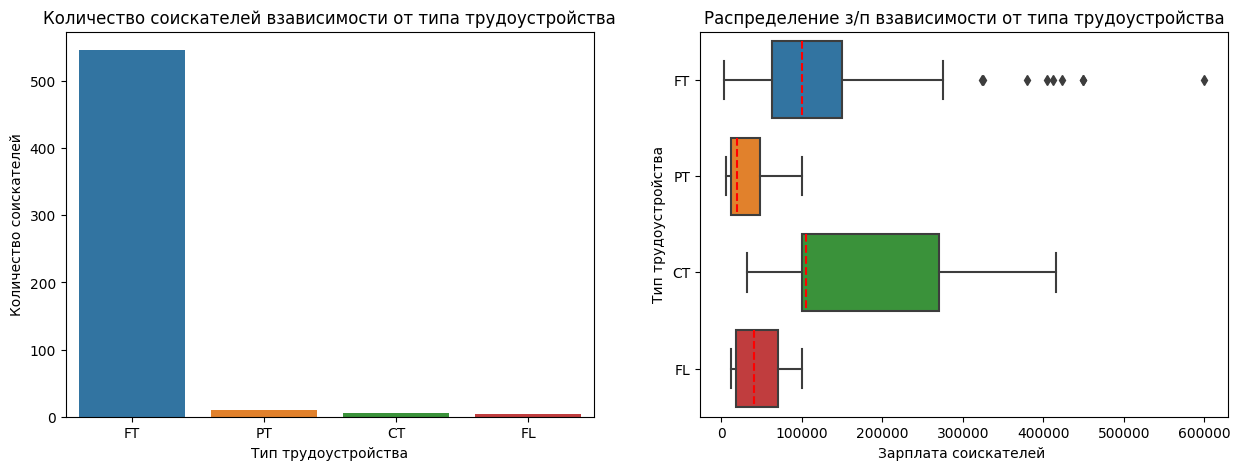

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_employment_type.index, y = cnt_employment_type['count'], ax=axes[0], order=['FT', 'PT', 'CT', 'FL'])
axes[0].set(xlabel='Тип трудоустройства', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от типа трудоустройства')


sns.boxplot(data, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, order=['FT', 'PT', 'CT', 'FL'])
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Тип трудоустройства')
axes[1].set_title('Распределение з/п взависимости от типа трудоустройства')

In [81]:
data_agg = data.groupby('employment_type')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от типа  трудоустройства:')
data_agg

Размера зарплаты взависимости от типа  трудоустройства:


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
CT,5.0,184575.00,156250.89,31875.0,100000.0,105000.0,270000.0,416000.0
FL,4.0,48000.00,40529.82,12000.0,18000.0,40000.0,70000.0,100000.0
FT,546.0,111811.84,70790.70,2859.0,62726.0,100000.0,150000.0,600000.0
PT,10.0,33070.50,31472.91,5409.0,12000.0,18817.5,48370.0,100000.0


In [82]:
data['employment_type'].value_counts(normalize=True) * 100

employment_type
FT    96.637168
PT     1.769912
CT     0.884956
FL     0.707965
Name: proportion, dtype: float64

Доля  типа трудоустройства FT составляет 96.63 %, тем  самым можно утверждать что практически все соискатели имели полный рабочий день. Можно данный столбец удалить т.к. он малоинформативный признак

In [83]:
data.drop('employment_type', axis=1, inplace=True)
data

,work_year,experience_level,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,Data Scientist,79833,DE,0,DE,L
1,2020,SE,Machine Learning Scientist,260000,other,0,other,S
2,2020,SE,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,Product Data Analyst,20000,other,0,other,S
4,2020,SE,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...
602,2022,SE,Data Engineer,154000,US,100,US,M
603,2022,SE,Data Engineer,126000,US,100,US,M
604,2022,SE,Data Analyst,129000,US,0,US,M
605,2022,SE,Data Analyst,150000,US,100,US,M


### Распределение заработной платы взависимости от общего объёма работы, выполняемой удалённо

In [84]:
cnt_remote_ratio = data['remote_ratio'].value_counts().to_frame()
cnt_remote_ratio.columns = ['count']

Text(0.5, 1.0, 'Распределение з/п взависимости от общего \n объема работы, выполняемой удаленно')

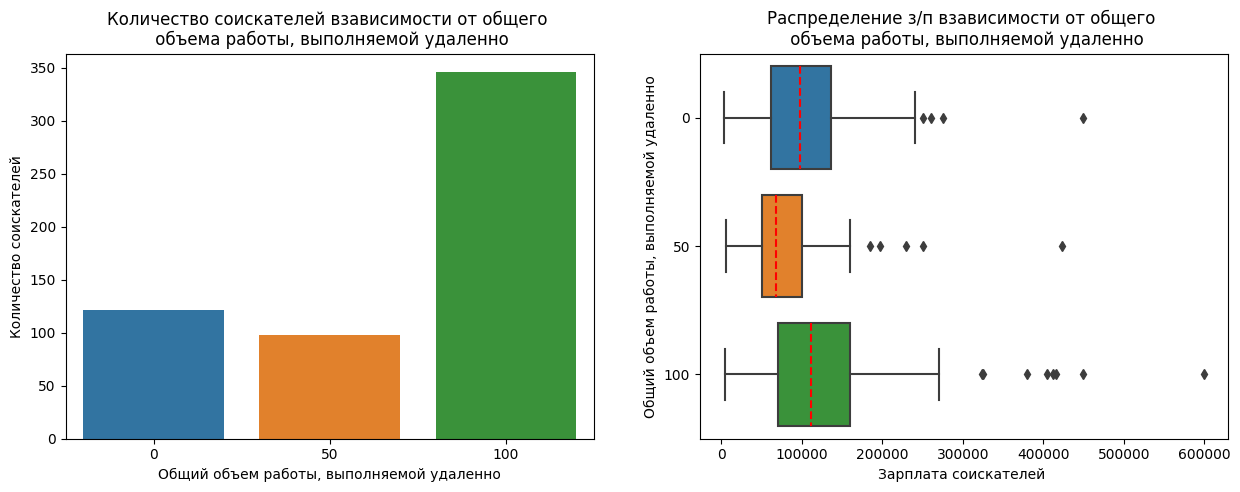

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_remote_ratio.index, y = cnt_remote_ratio['count'], ax=axes[0])
axes[0].set(xlabel='Общий объем работы, выполняемой удаленно', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от общего \n объема работы, выполняемой удаленно')


sns.boxplot(data, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Общий объем работы, выполняемой удаленно')
axes[1].set_title('Распределение з/п взависимости от общего \n объема работы, выполняемой удаленно')

In [86]:
data_agg = data.groupby('remote_ratio')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от общего  объема работы, выполняемой удаленно:')
data_agg

Размера зарплаты взависимости от общего  объема работы, выполняемой удаленно:


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,121.0,105785.40,68392.50,2859.0,62000.0,98158.0,136000.00,450000.0
50,98.0,80721.90,57639.10,5409.0,50000.5,68010.5,99925.75,423000.0
100,346.0,120763.19,74930.43,4000.0,70000.0,110712.5,159750.00,600000.0


Распределение зарплаты взависимости от  общего  объема работы, выполняемой удаленно отлично от нормального, имееются выбросы

### Распределение заработной платы взависимости от размера компании

In [87]:
cnt_company_size = data['company_size'].value_counts().to_frame()
cnt_company_size.columns = ['count']


Text(0.5, 1.0, 'Распределение з/п взависимости от размера компании')

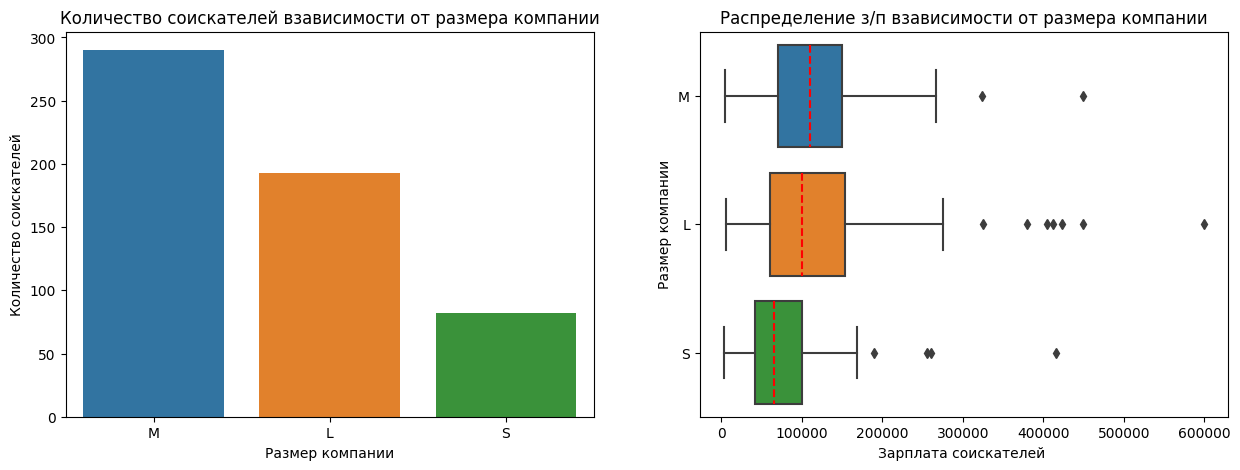

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_company_size.index, y = cnt_company_size['count'], ax=axes[0])
axes[0].set(xlabel='Размер компании', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от размера компании')


sns.boxplot(data, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, order=['M', 'L', 'S'])
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Размер компании')
axes[1].set_title('Распределение з/п взависимости от размера компании')

In [89]:
data_agg = data.groupby('company_size')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от размера компании:')
data_agg

Размера зарплаты взависимости от размера компании:


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
L,193.0,118213.88,86753.27,5882.0,60000.0,100000.0,153667.00,600000.0
M,290.0,114807.08,60779.04,4000.0,70821.5,109640.0,150213.75,450000.0
S,82.0,77872.10,63814.52,2859.0,41816.0,65511.0,100000.00,416000.0


Распределение зарплаты взависимости от  размера компании отлично от нормального, имееются выбросы

### Распределение заработной платы взависимости от страны проживания сотрудника в течение рабочего года

In [90]:
cnt_employee_residence = data['employee_residence'].value_counts().to_frame()
cnt_employee_residence.columns = ['count']

Text(0.5, 1.0, 'Распределение з/п взависимости от \n  страны проживания сотрудника')

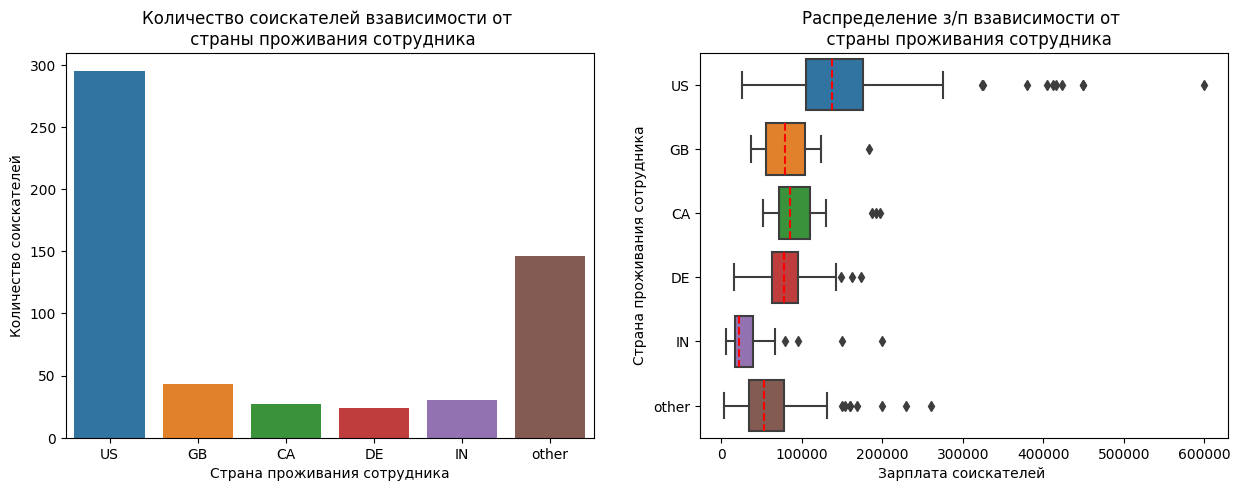

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_employee_residence.index, y = cnt_employee_residence['count'], ax=axes[0], order=['US', 'GB', 'CA', 'DE', 'IN', 'other'])
axes[0].set(xlabel='Страна проживания сотрудника', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от \n страны проживания сотрудника')


sns.boxplot(data, x='salary_in_usd', y='employee_residence', orient='h', medianprops={"color": "red", "linestyle": '--'}, 
            order=['US', 'GB', 'CA', 'DE', 'IN', 'other'])
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Страна проживания сотрудника')
axes[1].set_title('Распределение з/п взависимости от \n  страны проживания сотрудника')

In [92]:
data_agg = data.groupby('employee_residence')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от страны проживания сотрудника:')
data_agg

Размера зарплаты взависимости от страны проживания сотрудника:


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
CA,27.0,97191.63,40151.79,52000.0,71349.00,85000.0,110397.50,196979.0
DE,24.0,85336.67,40215.64,15966.0,62411.25,78015.0,94859.50,173762.0
GB,43.0,81470.07,30283.75,37300.0,55247.00,78526.0,103931.00,183228.0
IN,30.0,37322.33,43741.19,5409.0,16397.00,22124.0,38812.75,200000.0
US,295.0,150094.92,70918.56,25000.0,105200.00,138000.0,175550.00,600000.0
other,146.0,61107.58,42289.12,2859.0,34030.75,52256.5,77258.00,260000.0


Распределение зарплаты взависимости от  страны проживания сотрудника отлично от нормального, имееются выбросы

### Распределение заработной платы взависимости от страны главного офиса работодателя

In [93]:
cnt_company_location = data['company_location'].value_counts().to_frame()
cnt_company_location.columns = ['count']

Text(0.5, 1.0, 'Распределение з/п взависимости от \n  страны главного офиса работодателя')

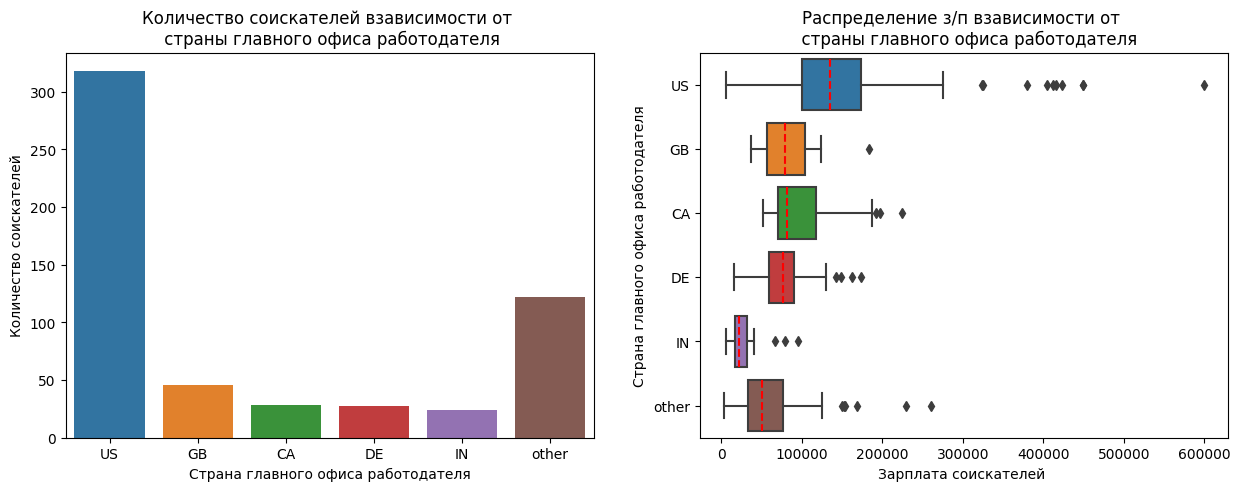

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x=cnt_company_location.index, y = cnt_company_location['count'], ax=axes[0], order=['US', 'GB', 'CA', 'DE', 'IN', 'other'])
axes[0].set(xlabel='Страна главного офиса работодателя', ylabel='Количество соискателей')
axes[0].set_title('Количество соискателей взависимости от \n страны главного офиса работодателя')


sns.boxplot(data, x='salary_in_usd', y='company_location', orient='h', medianprops={"color": "red", "linestyle": '--'}, 
            order=['US', 'GB', 'CA', 'DE', 'IN', 'other'])
axes[1].set(xlabel='Зарплата соискателей ', ylabel='Страна главного офиса работодателя')
axes[1].set_title('Распределение з/п взависимости от \n  страны главного офиса работодателя')

In [95]:
data_agg = data.groupby('company_location')['salary_in_usd'].describe().round(2)
print('Размера зарплаты взависимости от страны главного офиса работодателя:')
data_agg

Размера зарплаты взависимости от страны главного офиса работодателя:


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
CA,28.0,100121.86,47080.71,52000.0,70518.0,81895.5,117374.75,225000.0
DE,27.0,81559.56,39903.44,15966.0,58669.0,76833.0,89694.00,173762.0
GB,46.0,81649.50,29846.70,37300.0,56915.5,78526.0,104316.50,183228.0
IN,24.0,28581.75,22697.67,5409.0,16735.0,22124.0,32163.25,94665.0
US,318.0,144292.99,72524.34,5679.0,100000.0,135000.0,173000.00,600000.0
other,122.0,58707.48,41730.40,2859.0,32974.0,50090.0,76237.50,260000.0


Распределение зарплаты взависимости от  страны главного офиса работодателя отлично от нормального, имееются выбросы

## Статистический анализ данных

In [96]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# функция о выводе информации равенстве или нет   дисперсий        
def equal_var(p):
    if p <= alpha:
        print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
    else:
        print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.') 
               
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

In [97]:
# Оставим данные только относящиеся к специалистам  Data Scientist
ds_data = de_data = data[data['job_title'].isin(['Data Scientist'])]

In [98]:
ds_data_agg = ds_data.groupby('work_year')['salary_in_usd'].describe().round(2)
print('Размера зарплаты специалистам  Data Scientist взависимости от года, когда она была выплачена')
ds_data_agg

Размера зарплаты специалистам  Data Scientist взависимости от года, когда она была выплачена


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,21.0,85970.52,81436.65,21669.0,42197.00,62726.0,105000.00,412000.0
2021,44.0,70215.77,45843.82,2859.0,32793.75,67233.5,100922.75,165000.0
2022,65.0,131366.94,55785.24,18442.0,95550.00,135000.0,170000.00,260000.0


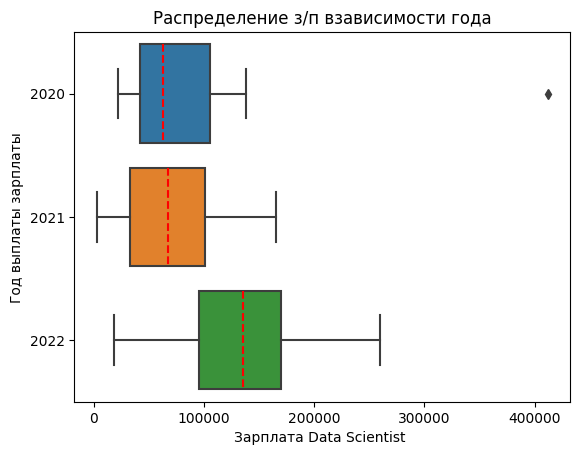

In [99]:
ax = sns.boxplot(ds_data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата Data Scientist ', ylabel='Год выплаты зарплаты')
plt.title('Распределение з/п взависимости года')
plt.show()

По коробчатой диграмме можно  утверждать что рост заработной платы наблюдается. Далее проведем по  данному вопросу статистические тесты. 

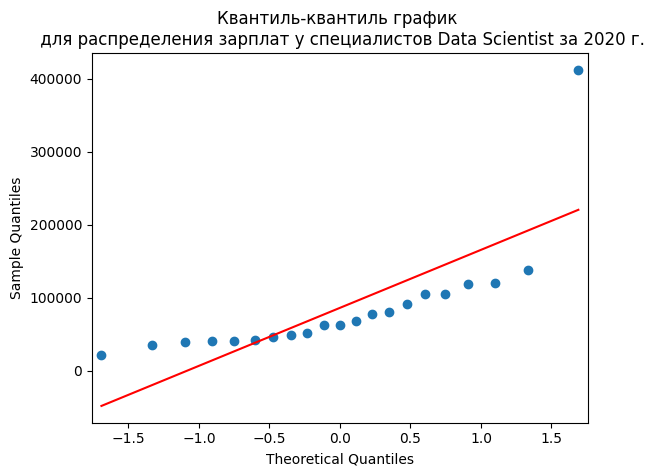

In [100]:
# Графически с помощью Q-Q Plot проверм на нормальность данные по зарплате за   2020г.
ds_data_2020 = ds_data.loc[ds_data['work_year']== 2020, 'salary_in_usd']
sm.qqplot(ds_data_2020, line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплат у специалистов Data Scientist за 2020 г.')

# отображаем квантиль-квантиль график
plt.show()


По графику можно  сделать   вывод , что  данные за 2020 распределены отлично от нормального 

Аналогично, производим с данными за 2021 и 2022 года.

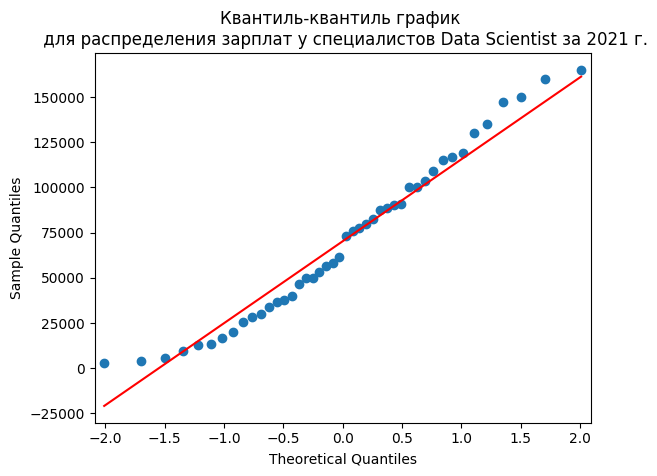

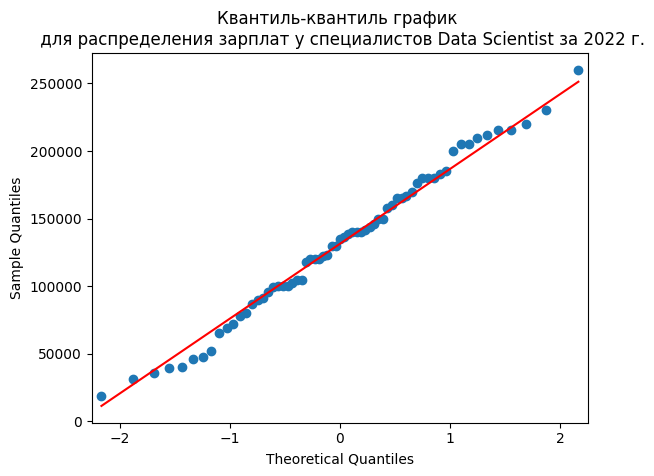

In [101]:
ds_data_2021 = ds_data.loc[ds_data['work_year']== 2021, 'salary_in_usd']
ds_data_2022 = ds_data.loc[ds_data['work_year']== 2022, 'salary_in_usd']

sm.qqplot(ds_data_2021, line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплат у специалистов Data Scientist за 2021 г.')
sm.qqplot(ds_data_2022, line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплат у специалистов Data Scientist за 2022 г.')
plt.show()


По гафикам можно сделать следующие выводы, что за 2021 распределение практически нормальное, за 2022 распределен нормально.
Для полной уверености провери выборки за 21 и 22 года с помощью теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [102]:
print('За 2021г.:')
result = stats.shapiro(ds_data_2021)
decision_normality(result[1])

print('За 2022г.:')
result = stats.shapiro(ds_data_2022)
decision_normality(result[1])

За 2021г.:
p-value = 0.107
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
За 2022г.:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


Попарно проверим по  годам  наблюдается ли рост заработной платы. 21 сравним с 20, а 21 с 22 

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер заработной платы за 2020г. ($μ_1$) статистически больше  либо равен размеру заработной платы за 2021г. ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы за 2020г. ($μ_1$) статистически меньше, чем размер заработной платы за 2021г. ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — одна выборка распределена нормальна, другая нет, поэтому будем  считать что обе отличны от нормального

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [103]:
# проводим тест
_, p = stats.mannwhitneyu(ds_data_2020, ds_data_2021, alternative='less')
decision_hypothesis(p)

p-value = 0.705
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Провелдем  статистические тесты по   заработной плате за 2021 и 2022 годы.

*Нулевая гипотеза* ($H_0$): размер заработной платы за 2021г. ($μ_1$) статистически больше  либо равен размеру заработной платы за 2022г. ($μ_2$).

$$ H_0 : μ_1 >= μ_2$$

*Альтернативная гипотеза* ($H_1$): размер заработной платы за 2021г. ($μ_1$) статистически меньше, чем размер заработной платы за 2022г. ($μ_2$).

$$ H_1 : μ_1 < μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — да

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный T-КРИТЕРИЙ.

**Проведём тест**

In [104]:
# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(ds_data_2021, ds_data_2022)
equal_var(result[1])

Тест на равенство дисперсий
Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.


In [105]:

_, p = stats.ttest_ind(ds_data_2021, ds_data_2022, alternative='less', equal_var=True)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


По проведенным статистическим тестам можно сделать вывод, что ежегодного роста у специалистов Data Scientist в период с 2020 - 2022 гг не наблюдается, но есть рост в период с 2021 - 2022 гг

### Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

In [106]:
# данные по специалистам Data Scientist имеются в ds_data , отфильтруем данные из  общей базы по специалистам Data Engineer
de_data = data[data['job_title'].isin(['Data Engineer'])]




Проиллюстрируем зарплаты данных специалистов

In [107]:

se_data = data[data['job_title'].isin(['Data Engineer', 'Data Scientist'])]


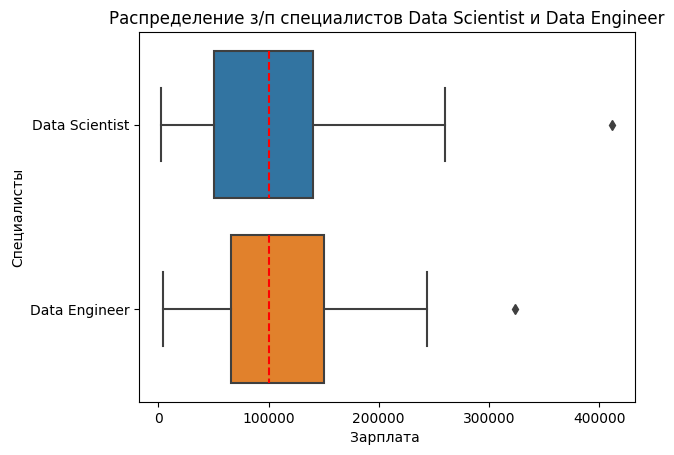

In [108]:
ax = sns.boxplot(se_data, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата ', ylabel='Специалисты')
plt.title('Распределение з/п специалистов Data Scientist и Data Engineer')
plt.show()

In [109]:
se_data_agg = se_data.groupby('job_title')['salary_in_usd'].describe().round(2)
print('Размера зарплаты  специалистов Data Scientist и Data Engineer')
se_data_agg

Размера зарплаты  специалистов Data Scientist и Data Engineer


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,121.0,109750.03,58203.68,4000.0,66022.00,100800.0,150000.0,324000.0
Data Scientist,130.0,103336.35,63967.56,2859.0,50330.25,100000.0,140400.0,412000.0


Графически видно, что медианна зарплаты специалистов Data Engineer практически одинаковая с Data Scientist. По основным статическим характеристикам ненамного больше. Проверим данный факт с помощью статистических тестов


С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [110]:
print('Зарплата Data Scientist:')
result = stats.shapiro(ds_data['salary_in_usd'])
decision_normality(result[1])

Зарплата Data Scientist:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


*Нулевая гипотеза* ($H_0$): Значение медианны зарплаты Data Scientist  ($μ_1$) статистически меньше  либо равно значению медианны зарплаты Data Engineer ($μ_2$).

$$ H_0 : μ_1 =< μ_2$$

*Альтернативная гипотеза* ($H_1$): Значение медианны зарплаты Data Scientist  ($μ_1$) статистически больше значению медианны зарплаты Data Engineer ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Признак распределён по нормальному закону? — нет

Чтобы проверить нашу гипотезу, можно использовать двухвыборочный КРИТЕРИЙ ЗНАКОВ (ДЛЯ ОДНОЙ ГРУППЫ).

**Проведём тест**

In [117]:
med_Data_Engineer = 100800 # медианна зарплаты Data_Engineer
_, p = sign_test(ds_data['salary_in_usd'], med_Data_Engineer)
decision_hypothesis(p)

p-value = 0.539
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Вывод медианна зарплаты Data_Engineer больше медианны зарплаты Data Scientist

Перейдем к сравнению зарплат должностей Data Scientist и Data Engineer за 2022.
Проверим на нормальность данные выборки

In [129]:
ds_2022 = ds_data[ds_data['work_year'].isin([2022])]
de_2022 = de_data[de_data['work_year'].isin([2022])]

print('Зарплата Data Scientist за 2022:')
result = stats.shapiro(ds_2022['salary_in_usd'])
decision_normality(result[1])

print('Зарплата Data Engineer за 2022:')
result = stats.shapiro(de_2022['salary_in_usd'])
decision_normality(result[1])

Зарплата Data Scientist за 2022:
p-value = 0.676
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата Data Engineer за 2022:
p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


*Нулевая гипотеза* ($H_0$): Значение  зарплаты Data Scientist  ($μ_1$) статистически меньше  либо равно значению зарплаты Data Engineer ($μ_2$).

$$ H_0 : μ_1 =< μ_2$$

*Альтернативная гипотеза* ($H_1$): Значение  зарплаты Data Scientist  ($μ_1$) статистически больше значению  зарплаты Data Engineer ($μ_2$).

$$ H_1 : μ_1 > μ_2$$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — одна выборка распределена нормальна, другая нет, поэтому будем  считать что обе отличны от нормального

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [131]:
# проводим тест
_, p = stats.mannwhitneyu(ds_2022['salary_in_usd'], de_2022['salary_in_usd'], alternative='greater')
decision_hypothesis(p)

p-value = 0.160
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Соотношение зарплат Data Scientist и Data Engineer в 2022 году в пользу Data Engineer. Зарплаты Data Engineer больше зарплат Data Scientist 

### Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Проверим на нормальность выборки зарплат  Data Scientist в зависимости от размера компании

In [134]:
ds_data_s = ds_data.loc[ds_data['company_size']== 'S', 'salary_in_usd']
ds_data_m = ds_data.loc[ds_data['company_size']== 'M', 'salary_in_usd']
ds_data_l = ds_data.loc[ds_data['company_size']== 'L', 'salary_in_usd']


In [136]:
print('Зарплата Data Scientist в компании, где менее 50 сотрудников')
result = stats.shapiro(ds_data_s)
decision_normality(result[1])

print('Зарплата Data Scientist в компании, где менее от 50 до 250 сотрудников')
result = stats.shapiro(ds_data_m)
decision_normality(result[1])

print('Зарплата Data Scientist в компании, где более 250 сотрудников')
result = stats.shapiro(ds_data_l)
decision_normality(result[1])

Зарплата Data Scientist в компании, где менее 50 сотрудников
p-value = 0.189
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата Data Scientist в компании, где менее от 50 до 250 сотрудников
p-value = 0.897
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Зарплата Data Scientist в компании, где более 250 сотрудников
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


*Нулевая гипотеза* ($H_0$): Значение  зарплаты Data Scientist  в различных размерах компании равны.

$$ H_0 : m_1 = m_2 = m_3$$

*Альтернативная гипотеза* ($H_1$):Значение  зарплаты Data Scientist  в различных размерах компании не равны.

$$ H_1 : m_1 \neq m_2 \neq m_3 $$

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — одна из трех выборка распределена нормальна, поэтому будем  считать, что все отличны от нормального

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [137]:
_, p = stats.kruskal(ds_data_s, ds_data_m, ds_data_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зарплата Data Scientist заисит от размера компании

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*:  между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь (признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «company_size»? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [139]:
# составляем таблицу сопряжённости
cross_table = pd.crosstab(se_data['company_size'], se_data['job_title'])

cross_table

job_title,Data Engineer,Data Scientist
company_size,,
L,34,43
M,81,66
S,6,21


In [140]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.



Существует статистически значимая взаимосвязь между  наличием должностей Data Scientist и Data Engineer и размером компании.

## Итоговые результаты исследования

* Ежегодного рост у специалистов Data Scientist в период с 2020 - 2022 гг не наблюдается, но есть рост в период с 2021 - 2022 гг
* Медианная зарплата за рассматриваемый период 2020 - 2022 гг у специалистов Data Engineer больше  чем у Data Scientist
* Соотношение зарплат Data Scientist и Data Engineer в 2022 году в пользу Data Engineer. Зарплаты Data Engineer больше зарплат Data Scientist 
* Зарплата Data Scientist заисит от размера компании
* Существует статистически значимая взаимосвязь между  наличием должностей Data Scientist и Data Engineer и размером компании.